[bokehのインタラクティブな可視化](https://qiita.com/driller/items/0730325bf5c1cd689979)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bokeh.plotting as bplt

from functools import reduce, lru_cache

from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook, push_notebook
from IPython.display import display
import ipywidgets as widgets
%matplotlib inline
bplt.output_notebook()

Loading BokehJS ...

Gibbs free energy

$$
    G_{T,P} = G_{T_0,P_0} + \int^T_{T_0}-S(T,P) dT + \int^P_{P_0} V(T,P) dP
$$

$$
    S(T,P) = S_{T_0,P_0} + \int^P_{P_0} -\alpha V(T,P) dP + \int^T_{T_0} \frac{Cp(T,P)}{T} dT
$$

$$
    V(T,P) = 
$$

固体については, 

$$
    Cp = Cp(T) = a + bT + \frac{c}{T^2} + \frac{d}{T^{1/2}} 
$$

$$
    \int^P_{P_0} -\alpha V(T,P) dP = 0
$$

$$
    V(T,P) = V_{T_0,P_0}
$$

気体については

$$
    V(T,P) = \frac{RT}{P}
$$

と置くことで

$$
    G_{T,P} = G_{T_0,P_0} + \int^T_{T_0} -\left( S_{T_0,P_0}+\int^{T'}_{T_0} \frac{Cp(T)}{T} dT\right) dT' + \int^P_{P_0} V(T,P) dP
$$

反応のGibbs自由エネルギー変化とは

$$
    \Delta_r G = \frac{\partial G}{\partial \xi}
$$

## Chapter 8

純粋な相からなる系における平衡条件.

反応α→βにおいて, 反応進行度ξにおける系全体のGibbs自由エネルギーは

$$
    G(\xi) = (1-\xi) \nu_\alpha \mu_\alpha^* + \xi \nu_\beta \mu_\beta ^*
$$

故に

$$
    \left( \frac{\partial G(\xi)}{\partial \xi} \right)_{T,P} = - \nu_\alpha \mu_\alpha^* + \nu_\beta \mu_\beta^*
$$

$\mu^*$は温度と圧力の関数なので, 上式が0になる温度圧力条件でαとβは共存しうる.

In [7]:

class Phase:
    cls_divNum = 100
    cls_T0 = 298 # K
    cls_P0 = 1e5 # Pa
    
    def __init__(self,name):                  # コンストラクタ
        self.name = name

        
    # a,b,c,d: kJ base
    def setCpParameters(self,a,b,c,d,Vmax=0,Smax=0,Tc0=0):
        self.a=a
        self.b=b
        self.c=c
        self.d=d
        self.Vmax=Vmax
        self.Smax=Smax
        self.Tc0 = Tc0
        
        

    
    def getCp(self,T,P=0):
        #Tc = self.Tc0 + self.Vmax/self.Smax * P
        #print(Tc)
        
        #exCp = 0
        #if (T < Tc):
        #    exCp = self.Smax * T / (2*np.sqrt(Tc*(Tc-T)))
        #else:
        #    exCp = 0
        #return exCp
        return  self.a + self.b * T + self.c / (T*T) + self.d/ np.sqrt(T) #+ exCp

    
    def setStandardCondition(self,H0=0,G0=0,V0=0,S0=0):
        self.H0 = H0
        self.G0=G0
        self.V0=V0
        self.S0=S0
        self.T0=Phase.cls_T0
        self.P0=Phase.cls_P0

    
    def getH(self,T,P,divNum=cls_divNum):
        dT = (T-self.T0)/divNum
        t = self.T0
        deltaH = 0
        for i in range(0,divNum):
            deltaH = deltaH + self.getCp(t) * dT
            t = t + dT
            
        return self.H0 + deltaH
    
    
    def getS(self,T,P,divNum=cls_divNum):
        #hashTP = str(T)+str(P)

        
        dT = (T-self.T0)/divNum
        t = self.T0
        deltaS = 0
        for i in range(0,divNum):
            deltaS = deltaS + self.getCp(t,P)/t * dT
            t = t + dT
            
        return self.S0 + deltaS
    
    
    def getV(self,T,P):
        return self.V0
    
    
    def getG(self,T,P,divNum=cls_divNum):
        dP = (P-self.P0)/divNum
        dT = (T-self.T0)/divNum
        p = self.P0
        t = self.T0
        deltaG = 0
        
        for i in range(0,divNum):
            deltaG = deltaG - self.getS(t,p) * dT + self.getV(t,p) * dP
            p = p + dP
            t = t + dT
        
        return self.G0 + deltaG
    
    @staticmethod
    def weighedSumOf(objects,method,w):
        def func(T,P):
            return reduce(lambda a,b: a+b, map(lambda o:o[0][method](T,P)*o[1], zip(objects,w) ))
        return func
    
    @staticmethod
    def getClapeylonSlope(phases,stoichiometry,T,P):
        return reduce(lambda a,b: a+b, map(lambda o:o[0].getS(T,P)*o[1], zip(phases,stoichiometry) ))/reduce(lambda a,b: a+b, map(lambda o:o[0].getV(T,P)*o[1], zip(phases,stoichiometry) ))
       
        
    @staticmethod
    def getEquilibriumT(phases,stoichiometry,P,Tini=cls_T0):
        deltaG=Phase.deltaGT(phases,stoichiometry,P)
        deltaS=Phase.deltaST(phases,stoichiometry,P)
        
        return newton(deltaG,deltaS,Tini)
    
    @staticmethod
    def getEquilibriumP(phases,stoichiometry,T,Pini = cls_P0):
        deltaG = Phase.deltaGP(phases,stoichiometry,T)
        deltaV = Phase.deltaVP(phases,stoichiometry,T)
        
        return newton(deltaG,deltaV,Pini)
        
    
    @staticmethod
    def getUnivariant(phases,stoichiometry,Pini=cls_P0, Tini = 298,Tmax=2000,divNum=cls_divNum):
        equiT = Phase.getEquilibriumT(phases,stoichiometry,Pini)
        
        if (Phase.getClapeylonSlope(phases,stoichiometry,equiT,Pini) > 0):
            dT = 1
        else:
            dT = -1
            
        TP=[]
        t=equiT
        p=Pini
        while( (Phase.cls_T0 < t) & (t < Tmax)):
                
            TP.append({"T":t,"P":p})
            t=t+dT
            slope=Phase.getClapeylonSlope(phases,stoichiometry,t,p)
        
            p=p+slope*dT
            
        return TP
        
            
        
    @staticmethod
    def deltaGT(phases,stoichiometry,P):
        def func(T):
            return reduce(lambda a,b: a+b, map(lambda o:o[0].getG(T,P)*o[1], zip(phases,stoichiometry) ))
        return func
    
    @staticmethod
    def deltaST(phases,stoichiometry,P):
        def func(T):
            return - reduce(lambda a,b: a+b, map(lambda o:o[0].getS(T,P)*o[1], zip(phases,stoichiometry) ))
        return func
    
    @staticmethod
    def deltaGP(phases,stoichiometry,T):
        def func(P):
            return reduce(lambda a,b: a+b, map(lambda o:o[0].getG(T,P)*o[1], zip(phases,stoichiometry) ))
        return func
    
    @staticmethod
    def deltaVP(phases,stoichiometry,T):
        def func(P):
            return reduce(lambda a,b: a+b, map(lambda o:o[0].getV(T,P)*o[1], zip(phases,stoichiometry) ))
        return func
    
    @staticmethod
    def coexist(phases,stoichiometry,name):
        # stoichiometory ! 
        phaseCombination = Phase(name)
        phaseCombination.setCpParameters(reduce(lambda a,b: a+b, map(lambda p:p[0].a*p[1],zip(phases,stoichiometry))),
                                         reduce(lambda a,b: a+b, map(lambda p:p[0].b*p[1],zip(phases,stoichiometry))),
                                         reduce(lambda a,b: a+b, map(lambda p:p[0].c*p[1],zip(phases,stoichiometry))),
                                         reduce(lambda a,b: a+b, map(lambda p:p[0].d*p[1],zip(phases,stoichiometry)))
                                        )
        phaseCombination.setStandardCondition(H0=reduce(lambda a,b: a+b, map(lambda p:p[0].H0*p[1],zip(phases,stoichiometry))),
                                              G0=reduce(lambda a,b: a+b, map(lambda p:p[0].G0*p[1],zip(phases,stoichiometry))),
                                              V0=reduce(lambda a,b: a+b, map(lambda p:p[0].V0*p[1],zip(phases,stoichiometry))),
                                              S0=reduce(lambda a,b: a+b, map(lambda p:p[0].S0*p[1],zip(phases,stoichiometry)))
                                             )

        return phaseCombination
    
    
class lambdaSolid(Phase):
    def __init__(self, name):
        super().__init__(name)

# quartzのようにランダウ理論に従って余剰エントロピーをもつ物質のクラスを作りたい #

    
def newton(f,df,prev,eps=1e-6):
    #print(prev)

    post = prev - f(prev)/df(prev)
    
    diff = np.abs(prev-post)
    
    if (diff < eps):
        return post
    else:
        return newton(f,df,post,eps)
        
def x2(t):
    return t*t-4
    
def dx2(t):
    return 2*t


## Example of $Al_2SiO_5$ minerals

In [26]:
kyanite = Phase("kyanite")
kyanite.setCpParameters(0.2794,-0.7124*1e-5,-2055.6,-2.2894)
kyanite.setStandardCondition(H0=-2593.11,G0=-2442.59,V0=4.414*1e-8,S0=83.5*1e-3)

print("Cp",kyanite.getCp(1020))
print("S",kyanite.getS(300,10e5))
print("H",kyanite.getH(1020,1e5,10000))

andalusite = Phase("andalusite")
andalusite.setCpParameters(0.2773,-0.6588*1e-5,-1914.1,-2.2656)
andalusite.setStandardCondition(H0=-2588.8,G0=-2440.97,V0=5.153*1e-8,S0=92.7*1e-3)
print(andalusite.getCp(1020))
print(andalusite.getH(300,1e5))

print((kyanite.getS(1073,1e5)-andalusite.getS(1073,1e5))*1e3,"J/mol K")

print(kyanite.getG(1073,1e5)-andalusite.getG(1073,1e5))


sillimanite = Phase("sillimanite")
sillimanite.setCpParameters(0.2802,-0.69*1e-5,-1375.7,-2.3994)
sillimanite.setStandardCondition(H0=-2585.68,G0=-2438.93,V0=4.986*1e-8,S0=95.5*1e-3)

slope = Phase.getClapeylonSlope([kyanite,andalusite],[-1,1],1020,1e5)
print(slope,"Pa/K")
#slope = Phase.getClapeylonSlope(andalusite,sillimanite,1020,1e5)
#print(slope,"Pa/K")
#slope = Phase.getClapeylonSlope(sillimanite,kyanite,1020,1e5)
#print(slope,"Pa/K")

equilibriumT=Phase.getEquilibriumT([kyanite,andalusite],[1,-1],1e8)
print("(T,P)e: (",equilibriumT,", 1e8)")
equilibriumP=Phase.getEquilibriumP([kyanite,andalusite],[1,-1],550.37)
print("(T,P)e: (550.37,",equilibriumP*1e-8,"*1e8)")


equilibriumT=Phase.getEquilibriumT([andalusite,sillimanite],[1,-1],1e8)
print("(T,P)e: (",equilibriumT,", 1e8)")
equilibriumP=Phase.getEquilibriumP([andalusite,sillimanite],[1,-1],1113.29)
print("(T,P)e: (1113.29,",equilibriumP*1e-8,"*1e8)")

equilibriumT=Phase.getEquilibriumT([sillimanite,kyanite],[1,-1],1e8)
print("(T,P)e: (",equilibriumT,", 1e8)")
equilibriumP=Phase.getEquilibriumP([sillimanite,kyanite],[1,-1],650.00)
print("(T,P)e: (650.00,",equilibriumP*1e-8,"*1e8)")

Cp 0.198473846853
S 0.0843152339066
H -2466.85105784
0.197801779142
-2588.5542142
-8.98067688861 J/mol K
5.52669062154
1219730.0842 Pa/K
(T,P)e: ( 550.370333681 , 1e8)
(T,P)e: (550.37, 0.999995781098 *1e8)
(T,P)e: ( 1113.29625864 , 1e8)
(T,P)e: (1113.29, 1.00006480213 *1e8)
(T,P)e: ( 650.000748536 , 1e8)
(T,P)e: (650.00, 0.999984773841 *1e8)


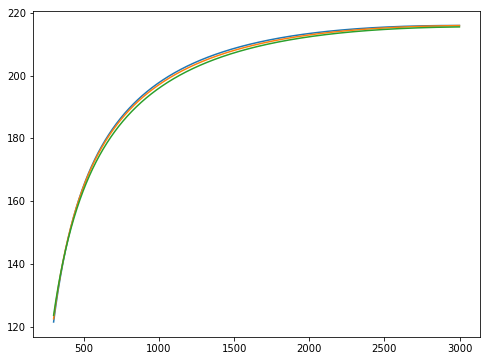

In [27]:
Ts = range(298,3000)
kyaniteCp = [kyanite.getCp(T)*1000 for T in Ts ]
andalusiteCp = [andalusite.getCp(T)*1000 for T in Ts]
sillimaniteCp = [sillimanite.getCp(T)*1000 for T in Ts]

fig = plt.figure(figsize=(8,6),facecolor="white")
ax = fig.add_subplot(1,1,1)

ax.plot(Ts,kyaniteCp)
ax.plot(Ts,andalusiteCp)
ax.plot(Ts,sillimaniteCp)

In [28]:
Pmin = 1e5
Pmax = 1e9


KyaAnd = Phase.getUnivariant([kyanite,andalusite],[-1,1])

AndSil = Phase.getUnivariant([andalusite,sillimanite],[-1,1])

SilKya = Phase.getUnivariant([sillimanite,kyanite],[-1,1])



TKA = [u["T"] for u in KyaAnd]
PKA = [u["P"] for u in KyaAnd]

TAS = [u["T"] for u in AndSil]
PAS = [u["P"] for u in AndSil]

TSK = [u["T"] for u in SilKya]
PSK = [u["P"] for u in SilKya]

p = figure(title="$Al_2SiO_5$", x_axis_label='T', y_axis_label='P')

p.line(TKA,PKA, legend="Kyanite-Andalusite", line_width=2,color="red")
p.line(TAS,PAS, legend="Andalusite-Sillimanite", line_width=2,color="green")
p.line(TSK,PSK, legend="Sillimanite-Kyanite", line_width=2,color="blue")

t=show(p, notebook_handle=True)

ValueError: Out of range float values are not JSON compliant

In [ ]:
pressure = list(map(lambda x:x*0.01*1e9,range(0,100)))

p = figure(title="Al2SiO5", x_axis_label='P', y_axis_label='G')

print(kyanite.getV(1000,1e5))

p.line(pressure,[kyanite.getG(1000,P) for P in pressure], legend = "Kya", color = "red")
p.line(pressure,[andalusite.getG(1000,P) for P in pressure], legend = "And", color = "blue")
p.line(pressure,[sillimanite.getG(1000,P) for P in pressure], legend = "Sil", color = "green")
t=show(p, notebook_handle=True)

In [8]:
Q = lambdaSolid("quartz")
Q.setCpParameters(0.1107,-0.5189*1e-5,0,-1.1283)
#Q.setCpTransition(Vmax=0.1188*1e-8,Smax=4.95*1e-3,Tc0=847)
Q.setStandardCondition(H0=-910.83,G0=-856.46,V0=2.269*1e-8,S0=41.5*1e-3)


print(Q.getS(900,1e5))

Pe = Phase("periclase")
Pe.setCpParameters(0.0605,0.0362*1e-5,-532.8,-0.2992)
Pe.setStandardCondition(H0=-601.6,G0=-569.34,V0=1.125*1e-8,S0=26.9*1e-3)

En=Phase("enstatite")
En.setCpParameters(0.3562,-0.299*1e-5,-596.9,-3.1853)
En.setStandardCondition(H0=-3090.47,G0=-2915.53,V0=6.262*1e-8,S0=132.5*1e-3)

Fo=Phase("forsterite")
Fo.setCpParameters(0.2333,0.1494*1e-5,-603.8,-1.8697)
Fo.setStandardCondition(H0=-2172.2,G0=-2052.75,V0=4.366*1e-8,S0=95.1*1e-3)



#p.line(pressure,[-Pe.getG(T,P) - En.getG(T,P)*0.5 + Fo.getG(T,P) for P in pressure],
#       legend = "Pe + En = Fo", color = "red")
#p.line(pressure,[+Pe.getG(T,P) + En.getG(T,P)*0.5 - Fo.getG(T,P) for P in pressure],
#       legend = "Pe + En = Fo", color = "red")

#p.line(pressure,[Pe.getG(T,P) + Q.getG(T,P) - En.getG(T,P)*0.5 for P in pressure],
#       legend = "Pe + Q = En", color = "blue")

cQ = Phase.coexist([Pe,En,Fo],[-2,-1,2],"(Q)")

cFo=Phase.coexist([Pe,Q,En],[-2,-2,1],"(Fo)")

cEn = Phase.coexist([Pe,Q,Fo],[-2,-1,1],"(En)")

cPe = Phase.coexist([Q,Fo,En],[-1,-1,1],"(Pe)")


print((-Pe.V0 - 0.5*En.V0 + Fo.V0)*1e9, "kJ/GPa")

print((-Pe.S0-0.5*En.S0 + Fo.S0)/(-Pe.V0 - 0.5*En.V0 + Fo.V0)*1e-5,"1e5 Pa/K")
#cQ = Phase.getUnivariant([Pe,En,Fo],[-1,-0.5,1],Pini = cQP,Tmax=6000)

#cPe = Phase.getUnivariant([Fo,Q,En],[-1,-1,1],Tmax=6000)

#cFo = Phase.getUnivariant([Pe,Q,En],[-1,-1,0.5],Tmax=6000)

#cEn = Phase.getUnivariant([Pe,Q,Fo],[-2,-1,1],Tmax=6000)

0.105445485607
1.0999999999999965 kJ/GPa
17.7272727272726 1e5 Pa/K


In [12]:

pressure = range(0,10000000000,100000000)
T = 500

p = figure(title=("SiO2-MgO at "+str(T)+" K"), x_axis_label='P', y_axis_label='ΔrG')
p.line(pressure,[cQ.getG(T,P) for P in pressure],legend="(Q)",color="red")
p.line(pressure,[cFo.getG(T,P) for P in pressure],legend="(Fo)",color="blue")
p.line(pressure,[cEn.getG(T,P) for P in pressure],legend="(En)",color="green")
p.line(pressure,[cPe.getG(T,P) for P in pressure],legend="(Pe)",color="black")
t=show(p, notebook_handle=True)

In [62]:


simpleQ = Phase("quartz")
simpleQ.setCpParameters(0.1107,-0.5189*1e-5,0,-1.1283)
simpleQ.setStandardCondition(H0=-910.83,G0=-856.46,V0=2.269*1e-8,S0=41.5*1e-3)


temperature = list(range(300,1000,10))
P = 1e5

print([Q.getCp(T,P) for T in temperature])

p = figure(title="Cp(T) of quartz", x_axis_label='T', y_axis_label='Cp')
p.line(temperature,[simpleQ.getCp(T,P) for T in temperature],legend="simpleQ",color="blue")

p.line(temperature,[Q.getCp(T,P) for T in temperature],legend="Q",color="red")

t=show(p, notebook_handle=True)



[0.045091669831270775, 0.04614588307381895, 0.047151024893706067, 0.048110960302723688, 0.049029160880127542, 0.049908756365366361, 0.05075257837979423, 0.051563197678765112, 0.052342956058379762, 0.053093993825080329, 0.053818273566720969, 0.054517600829898795, 0.055193642202152081, 0.05584794121306174, 0.056481932400745886, 0.057096953836237134, 0.057694258355133921, 0.058275023711717569, 0.058840361843919074, 0.059391327417001878, 0.059928925798823703, 0.06045412060957122, 0.060967840983709609, 0.061470988681613853, 0.061964445193302534, 0.062449078987579898, 0.062925753077852295, 0.063395333102644252, 0.063858696156919109, 0.064316740663359837, 0.064770397646052955, 0.0652206438701987, 0.065668517451753325, 0.066115136736920821, 0.066561723528144767, 0.067009632128884902, 0.067460386253345259, 0.067915726693527204, 0.068377673906858893, 0.068848611635843104, 0.069331400726753548, 0.069829537231287653, 0.070347377018728105, 0.070890463062873485, 0.071466016328070522, 0.0720836971104

ValueError: Out of range float values are not JSON compliant

In [64]:
p1 = figure(title="S of quartz", x_axis_label='T', y_axis_label='S')
p1.line(temperature,[simpleQ.getS(T,P,divNum=1024) for T in temperature],legend="simpleQ",color="blue")

p1.line(temperature,[Q.getS(T,P,divNum=1024) for T in temperature],legend="Q",color="red")
t1=show(p1, notebook_handle=True)

ValueError: Out of range float values are not JSON compliant

In [19]:
uQ = Phase.getUnivariant([Pe,En,Fo],[-1,-0.5,1],Tmax=6000)

uPe = Phase.getUnivariant([Fo,Q,En],[-1,-1,1],Tmax=6000)

uFo = Phase.getUnivariant([Pe,Q,En],[-1,-1,0.5],Tmax=6000)

uEn = Phase.getUnivariant([Pe,Q,Fo],[-2,-1,1],Tmax=6000)

p = figure(title="SiO2-MgO", x_axis_label='T', y_axis_label='ΔrG')

298
-12853.2820513
nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


KeyboardInterrupt: 

In [ ]:

temperature = list(range(1000,4000,10))
P = 0.7e11

p = figure(title="SiO2-MgO", x_axis_label='T', y_axis_label='ΔrG')
p.line(temperature,[cQ.getG(T,P) for T in temperature],legend="(Q)",color="red")
p.line(temperature,[cFo.getG(T,P) for T in temperature],legend="(Fo)",color="blue")
p.line(temperature,[cEn.getG(T,P) for T in temperature],legend="(En)",color="green")
p.line(temperature,[cPe.getG(T,P) for T in temperature],legend="(Pe)",color="black")
t=show(p, notebook_handle=True)

In [14]:
p = figure(title="SiO2-MgO", x_axis_label='T', y_axis_label='Cp')

T = list(range(300,4000,10))
P=1e5

p.line(T,[Q.getCp(t) for t in T], legend="Q", color="red")
p.line(T,[Pe.getCp(t) for t in T], legend="Pe", color="blue")
p.line(T,[En.getCp(t)*0.5 for t in T], legend="En", color="green")
p.line(T,[Fo.getCp(t) for t in T], legend="Fo", color="black")


t=show(p, notebook_handle=True)

## Example of $SiO_2 - MgO - Al_2O_3$ system

In [ ]:
Q = Phase("quartz")
Q.setCpParameters(0.1107,-0.5189*1e-5,0,-1.1283)
Q.setStandardCondition(H0=-910.83,G0=-856.46,S0=41.5*1e-3,V0=2.269*1e-8)

Cd = Phase("cordielrite")
Cd.setCpParameters(0.8213,4.3339*1e-5,-8211.2,-5)
Cd.setStandardCondition(H0=-9163.37,G0=-8653.24,S0=407.5*1e-3,V0=23.322*1e-8)

Pe = Phase("periclase")
Pe.setCpParameters(0.0605,0.0362*1e-5,-532.8,-0.2992)
Pe.setStandardCondition(H0=-601.6,G0=-569.34,S0=26.9*1e-3,V0=1.125*1e-8)

Sp = Phase("spinel")
Sp.setCpParameters(0.2427,-0.6035*1e-5,-2315.1,-1.6781)
Sp.setStandardCondition(H0=-2300.72,G0=-2175.64,S0=81.5*1e-3,V0=3.9878*1e-8)

Co = Phase("corundum")
Co.setCpParameters(0.1395,0.589*1e-5,-2460.6,-0.5892)
Co.setStandardCondition(H0=-1675.25,G0=-1581.72,S0=50.9*1e-3,V0=2.558*1e-8)

print(Phase.getEquilibriumT([Cd,Q,Sp],[-1,5/7,2/7],1e5))
print(Phase.getClapeylonSlope([Cd,Q,Sp],[-1,5/7,2/7],972,1e5),"Pa/K")
print(Phase.getEquilibriumT([Sp,Co,Pe],[-1,1/2,1/2],1e10))
cCoPe=Phase.getUnivariant([Cd,Q,Sp],[-1,5/7,2/7],Pini=1e9,Tmax=15000)
#print(cCoPe)
cQCd = Phase.getUnivariant([Sp,Co,Pe],[-1,1/2,1/2],Pini=1e10,Tmax=15000)
cSp=Phase.getUnivariant([Q,Pe,Co,Cd],[-5/9,-2/9,-2/9,1],Pini=1e10,Tmax=15000)


p = figure(title="SiO2-MgO-Al2O3", x_axis_label='T', y_axis_label='P')

T=[u["T"] for u in cCoPe]
P=[u["P"] for u in cCoPe]
p.line(T,P, legend="(Co)(Pe)", line_width=2,color="red")

T=[u["T"] for u in cQCd]
P=[u["P"] for u in cQCd]
p.line(T,P, legend="(Q)(Cd)", line_width=2,color="blue")

T=[u["T"] for u in cSp]
P=[u["P"] for u in cSp]
p.line(T,P, legend="(Sp)", line_width=2,color="green")
#p.line(TAS,PAS, legend="Andalusite-Sillimanite", line_width=2,color="green")
#p.line(TSK,PSK, legend="Sillimanite-Kyanite", line_width=2,color="blue")

t=show(p, notebook_handle=True)

In [ ]:
reduce(lambda a,b: a+b, map(lambda p:p[0].getS(1020,1e5)*p[1],zip([kyanite,andalusite],[2,2])))


In [32]:
Tc=847
T=846
print(1/2*np.sqrt(Tc*(Tc-T)))

14.5516322109
